Linear Discriminant Analysis (LDA) is most commonly used as dimensionality reduction technique in the pre-processing step for pattern-classification and ML applications. The goal is to project a dataset onto a lower-dimensional space with good class-separability in order to avoid overfitting and also reduce computational costs

<b> The general LDA approach is very similar to prinicipal component analysis, but in addition to finding the component axes that maximize the variance of our data(PCA) we are additionaly interested in the axes that maximize the separation between multiple classes(LDA) </b>

# Summarizing the LDA approach in 5 steps

The following are the five steps for performing the Linear Discriminant analysis;

1) Compute the d-dimensional mean vectors for the different classes from the dataset

2) Compute the scatter matrices (in-between-class and within-class scatter matrix)

3) Compute the eigenvectors(e1, e2,...., ed) and corresponding eigenvalues(λ1,λ2,...,λd) for the scatter matrices.

4) Sort the eigenvectors by decreasing eigenvalues and choose k eigenvectors with the largest eigenvalues to form a d x k dimensional matrix W (where every column represents an eigenvector)

5) Use this d x k eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the matrix multiplication: Y = X x W (where X is an n x d dimensional matrix representing the n samples and y are transformed n x k-dimensional samples in the new subspace)

In [19]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')


-- The sum of explained variances — and must be equal to 1:
	 1.0
-- Explained variance percentage per principal component:
	 ['99.121', '0.879', '0.000', '-0.000']
--Dimensionality-reduction: ----------

	Shape of X: (150, 4)

	Shape of transformed X: (150, 2)

-- Linear Discriminants information:
        LD1       LD2  flower
0  1.499210 -1.886754  setosa
1  1.264360 -1.592143  setosa
2  1.355253 -1.733415  setosa
3  1.184956 -1.623588  setosa
4  1.516956 -1.944762  setosa


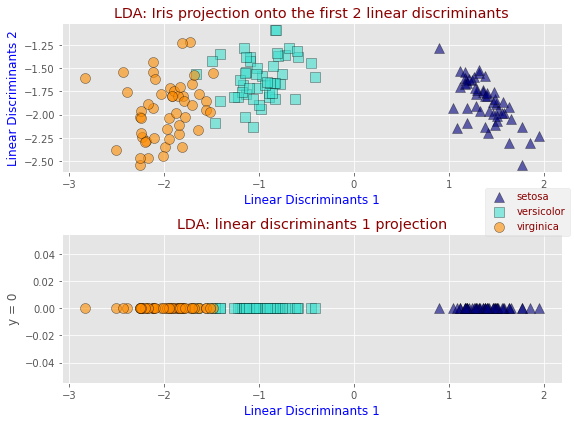

In [25]:
class LDA:
    """ Linear Discriminant Analysis """
    """
        Linear Discriminant Analysis (LDA) is most commonly used as dimensionality reduction technique
        in the pre-processing step for pattern-classification and machine learning applications. 
        The goal is to project a dataset onto a lower-dimensional space with good class-separability 
        in order avoid over-fitting (“curse of dimensionality”) and also reduce computational costs.
    The general LDA approach is very similar to a Principal Component Analysis 
    """

    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None
        self.eigenvalues = None

    def fit(self, X, y):
        # STANDARDIZATION OF FEATURE DATA:
        scaled_features = scaling_data(X)

        # Get the no of features
        n_features = X.shape[1]
        # Get the flower labels
        flower_classes = np.unique(y)
        # Compute the overall mean of X
        mean_overall = np.mean(X, axis=0)
        # Initialize within-class scatter matrix
        Sw = np.zeros((n_features, n_features))
        # Initialize between-class scatter matrix
        Sb = np.zeros((n_features, n_features))

        for cls in flower_classes:
            # Get all the flower class samples from X
            samples_of_class = X[y == cls]

            # Step 1: Computing the mean vector of the flower class
            # mi = 1 / ni ∑x ∈ Di:n (xk)
            mean_vector_of_cls = np.mean(samples_of_class, axis=0)

            # Step 2: Computing the within-class scatter matrix for every class - Sw
            S = samples_of_class - mean_vector_of_cls
            # Si = ∑x∈Di:n (x−mi)(x−mi).T
            Si = np.dot(S.T, S)  # maintain the size of the matrix (4, 4)
            # Sum class scatter matrices : Sw = ∑i=1:c Si
            Sw += Si

            # Step 3: Computing the between-class scatter matrix for every class - Sb
            # Sb = ∑i=1:c Ni(mi−m)(mi−m)T, where m  is the overall mean,
            # and mi and Ni are the sample mean and sizes of the respective classes.
            # Compute the samples for the flower class
            n_samples_of_class = samples_of_class.shape[0]
            S = mean_vector_of_cls - mean_overall
            # make column vectors
            mean_diff = S.reshape(n_features, 1)

            Sb += n_samples_of_class * np.dot(mean_diff, mean_diff.T)

        # Step 4: Solving the generalized eigenvalue problem for the matrix SW^-1.SB
        # Compute SW^-1.SB
        A = np.dot(np.linalg.inv(Sw), Sb)
        # Compute eigenvalues and eigenvectors
        self.eigenvalues, eigenvectors = np.linalg.eig(A)
        # Transpose eigenvector - v = [:,i] column vector, for easier calculations
        # transposed_eigenvectors = eigenvectors[:,i].reshape(4,1)
        transposed_eigenvectors = eigenvectors.T
        # Get the indices of the sort eigenvalues in descendant-order
        sorted_indices = np.argsort(abs(self.eigenvalues))[::-1]
        # Get the final eigenvectors from the transposed_eigenvectors and sorted_indices
        eigenvectors = transposed_eigenvectors[sorted_indices]
        # Dimensionality reduction: choose to keep only p eigenvectors (linear_discriminants)
        # out of n_components
        self.linear_discriminants = eigenvectors[0:self.n_components]

    def transform(self, X):
        # FINAL STEP: PROJECT THE DATA ALONG THE  LINEAR DISCRIMINANTS AXES
        # Transforming the samples onto the new subspace
        projected_vectors = np.dot(X, self.linear_discriminants.T)

        return projected_vectors


def explained_variance(e_values):
    e_variances = []
    for i in range(len(e_values)):
        ev = e_values[i] / np.sum(e_values)
        e_variances.append(ev)
    # The first value is just the sum of explained variances — and must be equal to 1
    print('\n-- The sum of explained variances — and must be equal to 1:\n\t', np.sum(e_variances))
    # The second value is an array, representing the explained variance percentage per principal component.
    ev = [format(x * 100, '.3f') for x in e_variances]
    print('-- Explained variance percentage per principal component:\n\t', ev)


def scaling_data(x):
    """ Scaling or standardizing our training and test data """
    """
        -- Data standardization is the process of rescaling the attributes so that they have 
            mean as 0 and variance as 1.
        -- The ultimate goal to perform standardization is to bring down all the features to 
            a common scale without distorting the differences in the range of the values.
        -- In sklearn.preprocessing.StandardScaler(), centering and scaling happens independently 
            on each feature.
    """
    scaler = StandardScaler()  # Standardize features by removing the mean and scaling to unit variance
    """
        The "fit method" is calculating the mean and variance of each of the features present in our data. 
        The "transform" method is transforming all the features using the respective mean and variance.
    """
    scaled_x = scaler.fit_transform(x)

    return scaled_x


def get_data(data):
    # Create a pandas data frame from iris data
    iris_df = pd.DataFrame(data.data, columns=data.feature_names)
    # Append a target to the data frame
    iris_df['target'] = data.target
    # Create X and y by dropping some columns from iris data frame
    x = iris_df.drop(['target'], axis='columns')
    y = iris_df['target']

    return x, y


def plot_lda(ld):

    x = ld['LD1']
    y = ld['LD2']
    flowers = np.unique(ld['flower'])

    plt.style.use('ggplot')
    fig = plt.figure(figsize=(8, 6))
    ax1 = fig.add_subplot(211)  # add_subplot(nrows, ncols, index, **kwargs)
    ax2 = fig.add_subplot(212)

    markers, colors = ('^', 's', 'o'), ('navy', 'turquoise', 'darkorange')
    for label, marker, color in zip(flowers, markers, colors):
        ax1.scatter(x[ld['flower'] == label]
                    , y[ld['flower'] == label]
                    , color=color
                    , marker=marker
                    , s=100
                    , edgecolors='k'
                    , alpha=0.6
                    , label=label)

        ax2.scatter(x[ld['flower'] == label]
                    , y=[0] * len(x[ld['flower'] == label])
                    , color=color
                    , marker=marker
                    , s=100
                    , edgecolors='k'
                    , alpha=0.6)

    ax1.set_title('LDA: Iris projection onto the first 2 linear discriminants',  color='darkred')
    ax1.set_xlabel('Linear Discriminants 1', color='blue')
    ax1.set_ylabel('Linear Discriminants 2', color='blue')
    #ax1.grid()

    ax2.set_title('LDA: linear discriminants 1 projection', color='darkred')
    ax2.set_xlabel('Linear Discriminants 1', color='blue')
    ax2.set_ylabel('y = 0')
    #ax2.grid()

    fig.legend(loc='center right',
               fancybox=True,
               framealpha=0.5,
               labelcolor='darkred')
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # Load Iris dataset
    iris = datasets.load_iris()
    # Get features and target
    features, target = get_data(iris)

    # Project the data onto the 2 primary principal components
    components = 2
    lda = LDA(n_components=components)
    lda.fit(np.array(features), target)
    X_projected = lda.transform(np.array(features))

    # print the explained variances
    explained_variance(lda.eigenvalues)

    print('--Dimensionality-reduction: ----------')
    print('\n\tShape of X:', features.shape)
    print('\n\tShape of transformed X:', X_projected.shape)

    # Create a Linear Discriminants dataframe
    print('\n-- Linear Discriminants information:')
    ld_df = pd.DataFrame(X_projected, columns=['LD' + str(i + 1) for i in range(components)])
    ld_df['flower'] = target.apply(lambda x: iris.target_names[x])
    print(ld_df.head())

    plot_lda(ld_df)